In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyBigWig
from glob import glob
from multiprocessing import Pool
from tqdm import tqdm
from itertools import repeat

import sys
sys.path.insert(1, '../') 

from src import atac_seq, plot_mC

In [2]:
me_type = 'L1'
region = 1000

In [3]:
atac_files = '/home/AD/rkgadde/L1IP/atac_data/bigwig/*.bw'
me_file = f'/home/AD/rkgadde/L1IP/mC_data/CZI/type/vars/non-polymorphic_ref{me_type}.bed'
mc_file = f'/home/AD/rkgadde/L1IP/mC_data/CZI/type/mC/binc-20.np{me_type}.all_samples.parquet.gz'
figdir = '/home/AD/rkgadde/L1IP/results/CZI/plots/reference/ATAC'

In [4]:
atac_celltypes = {'ITL23': 'L2-4IT', 
                  'ITL34': 'L3-5IT', 
                  'ITL45': 'L4-5IT', 
                  'ITL6_1': 'L6IT', 
                  'CT': 'L6CT', 
                  'L6B': 'L6b', 
                  'LAMP5': 'LAMP5',
                  'LAMP5_LHX6': 'LAMP5 LHX6', 
                  'VIP': 'VIP',
                  'SST': 'SST', 
                  'PVALB': 'PVALB'}

In [5]:
mc_celltypes = {'L2-4IT_CUX2': 'L2-4IT', 
                'L3-5IT_RORB_PLCH1': 'L3-5IT', 
                'L4-5IT_RORB_TSHZ2': 'L4-5IT', 
                'L4-5IT_RORB_LRRK1': 'L4-5IT',
                'L4-5IT_RORB_ARHGAP15': 'L4-5IT', 
                'L6IT_THEMIS_LINC00343': 'L6IT',
                'L6IT_THEMIS_CUX1': 'L6IT', 
                'L6CT_TLE4_FAM95C': 'L6IT',
                'L6CT_TLE4_FAM95C': 'L6CT', 
                'L6b_TLE4_NXPH4': 'L6b',
                'CGE_LAMP5': 'LAMP5', 
                'CGE_LAMP5_LHX6': 'LAMP5 LHX6',
                'CGE_VIP': 'VIP', 
                'MGE_SST': 'SST', 
                'MGE_PVALB': 'PVALB'}

In [6]:
bigwigs = glob(atac_files)

with Pool(16) as p:
    dfs = list(tqdm(p.starmap(atac_seq.get_bw_signal, zip(bigwigs, repeat(me_file), repeat(region)))))

100%|██████████| 11/11 [00:00<00:00, 15958.96it/s]


In [7]:
bw_df = pd.concat(dfs)
bw_df['celltype'] = bw_df['celltype'].map(atac_celltypes) # map cell types (1-1 mapping)
bw_df = bw_df.explode(['bin','signal'])

In [8]:
mc_df = pd.read_parquet(mc_file)
mc_df = mc_df[mc_df['ctxt'] == 'mCH']
mc_df['celltype'] = mc_df['celltype'].map(mc_celltypes) # map cell types to shared types

In [ ]:
mc_df['subfamily'] = mc_df['id'].str.extract(r'(.*)_[0-9]+')

: 

In [ ]:
# Aggregate signal over loci
bw_group = bw_df.groupby(['bin','celltype','subfamily'])['signal'].mean()
bw_map = bw_group.reset_index()

# bw_map['celltype'] = bw_map['celltype'].map(atac_celltypes) # map cell types (1-1 mapping)

In [ ]:
# Aggregate mC over loci
# Due to the size of the data frame, it's faster to map cell types after aggregation then re-aggregate
mc_group = plot_mC.aggregate_mC_by_sum(mc_df, ['bin','celltype','subfamily'])
mc_map = mc_group.reset_index()
# mc_map['celltype'] = mc_map['celltype'].map(mc_celltypes) # map cell types to shared types
# mc_map = plot_mC.aggregate_mC_by_sum(mc_map.dropna(), ['bin','celltype','subfamily']) # re-aggregate with new cell types

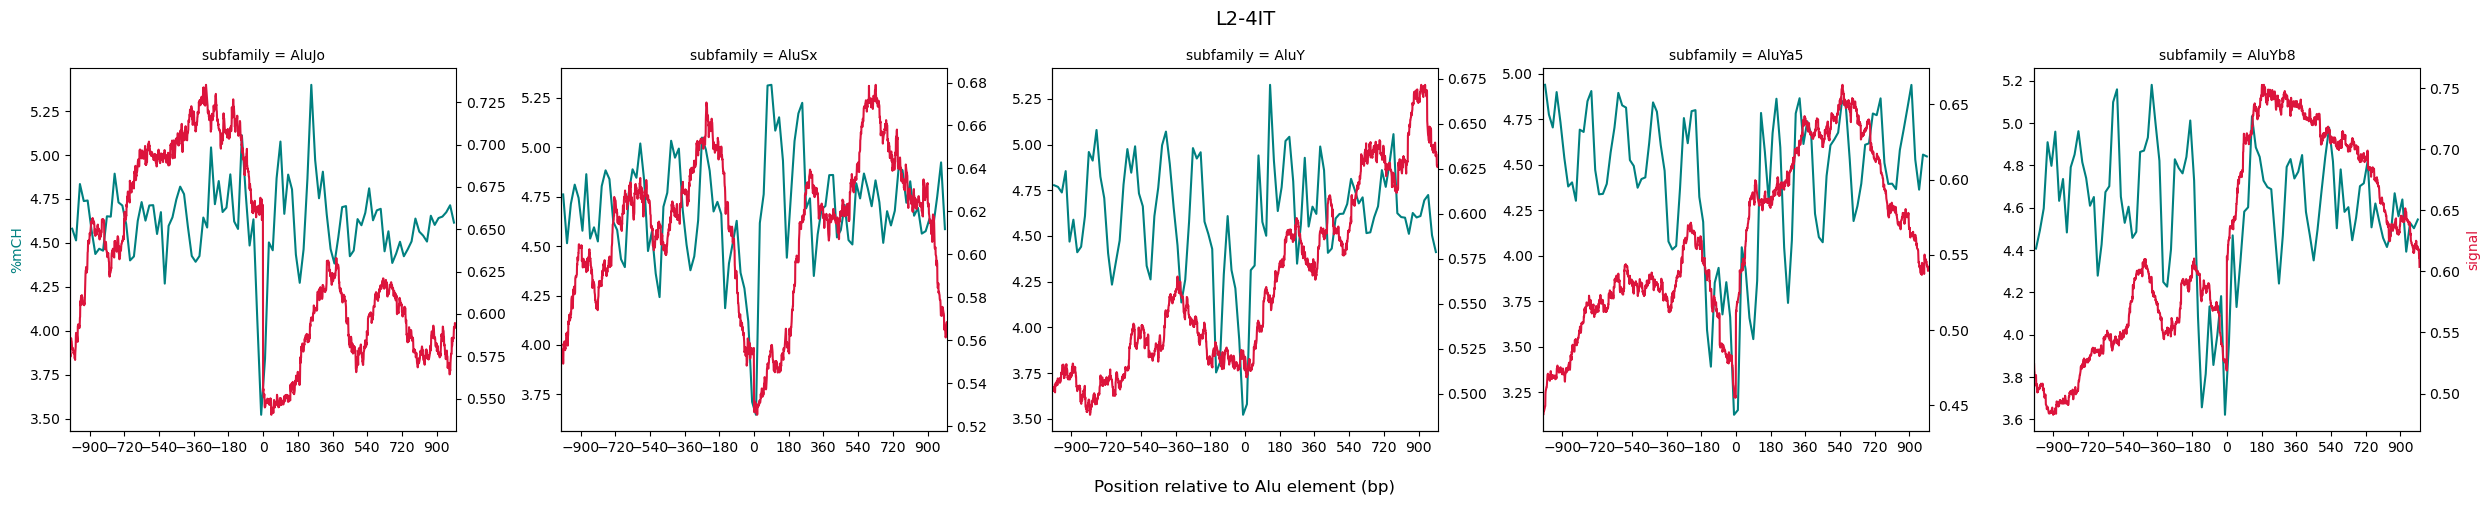

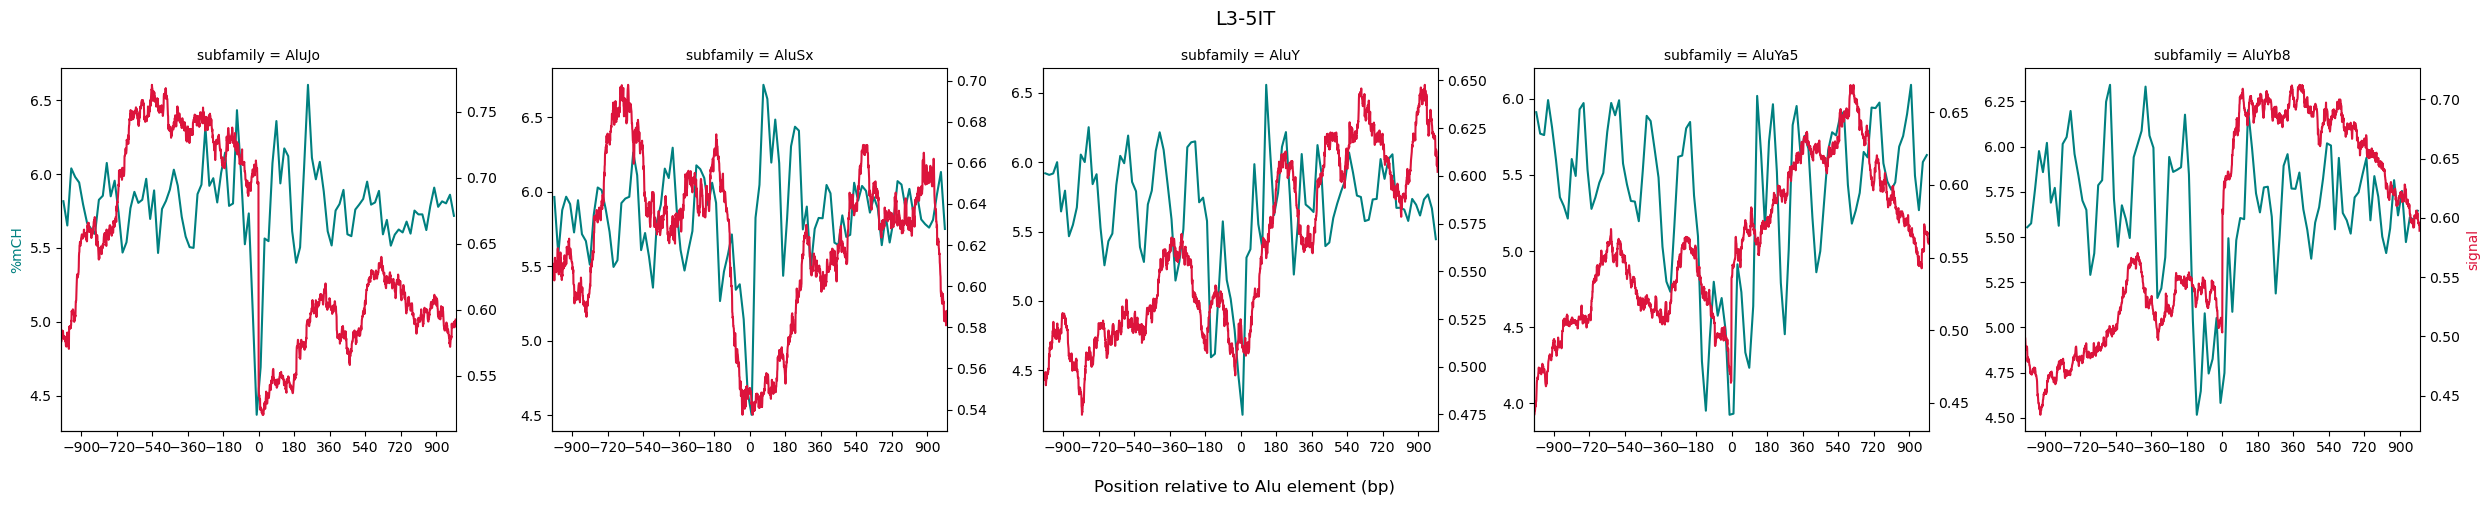

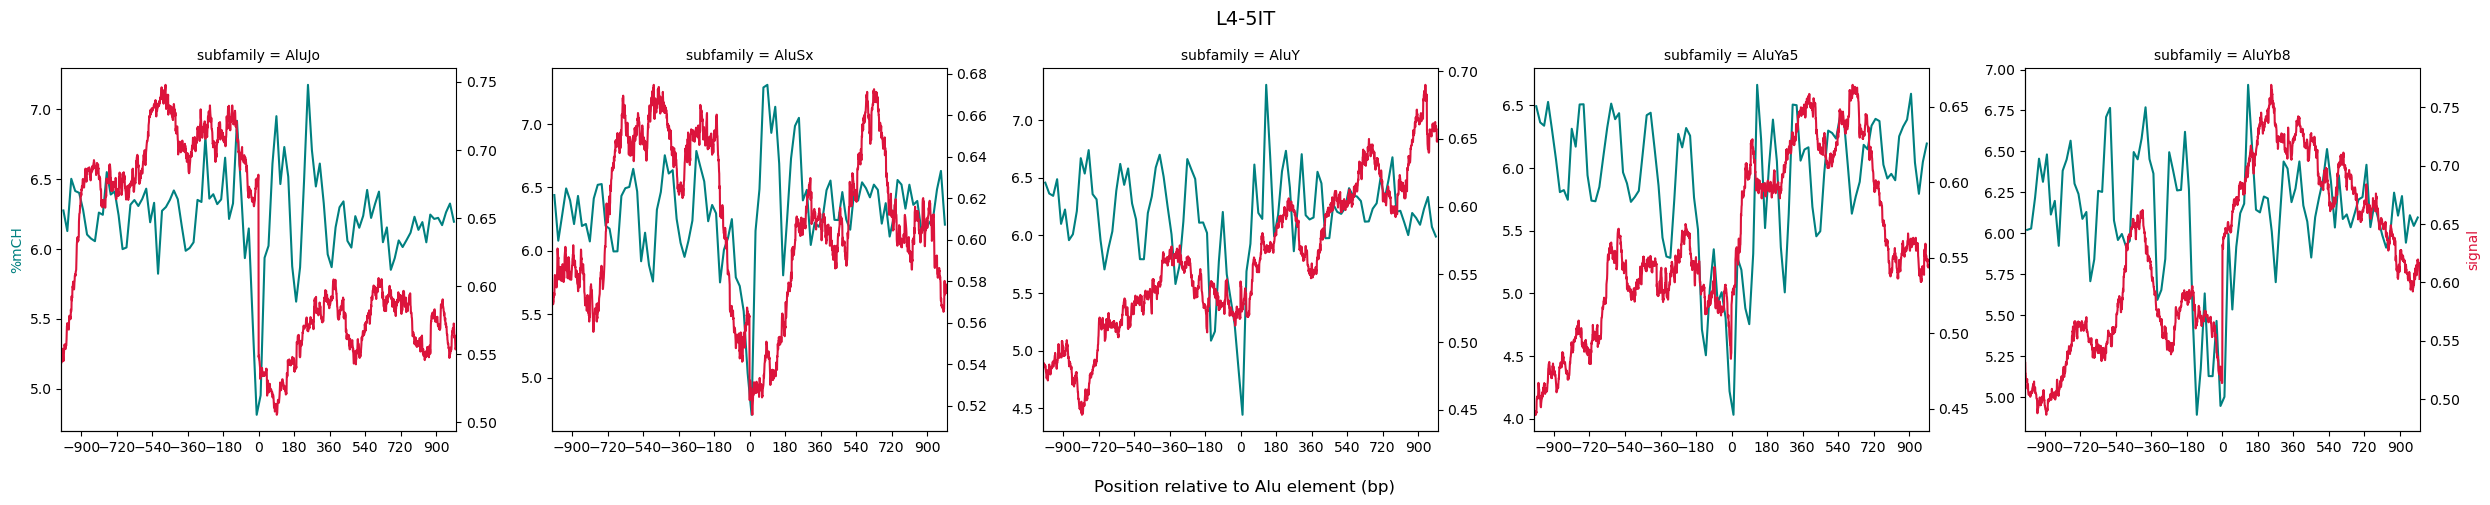

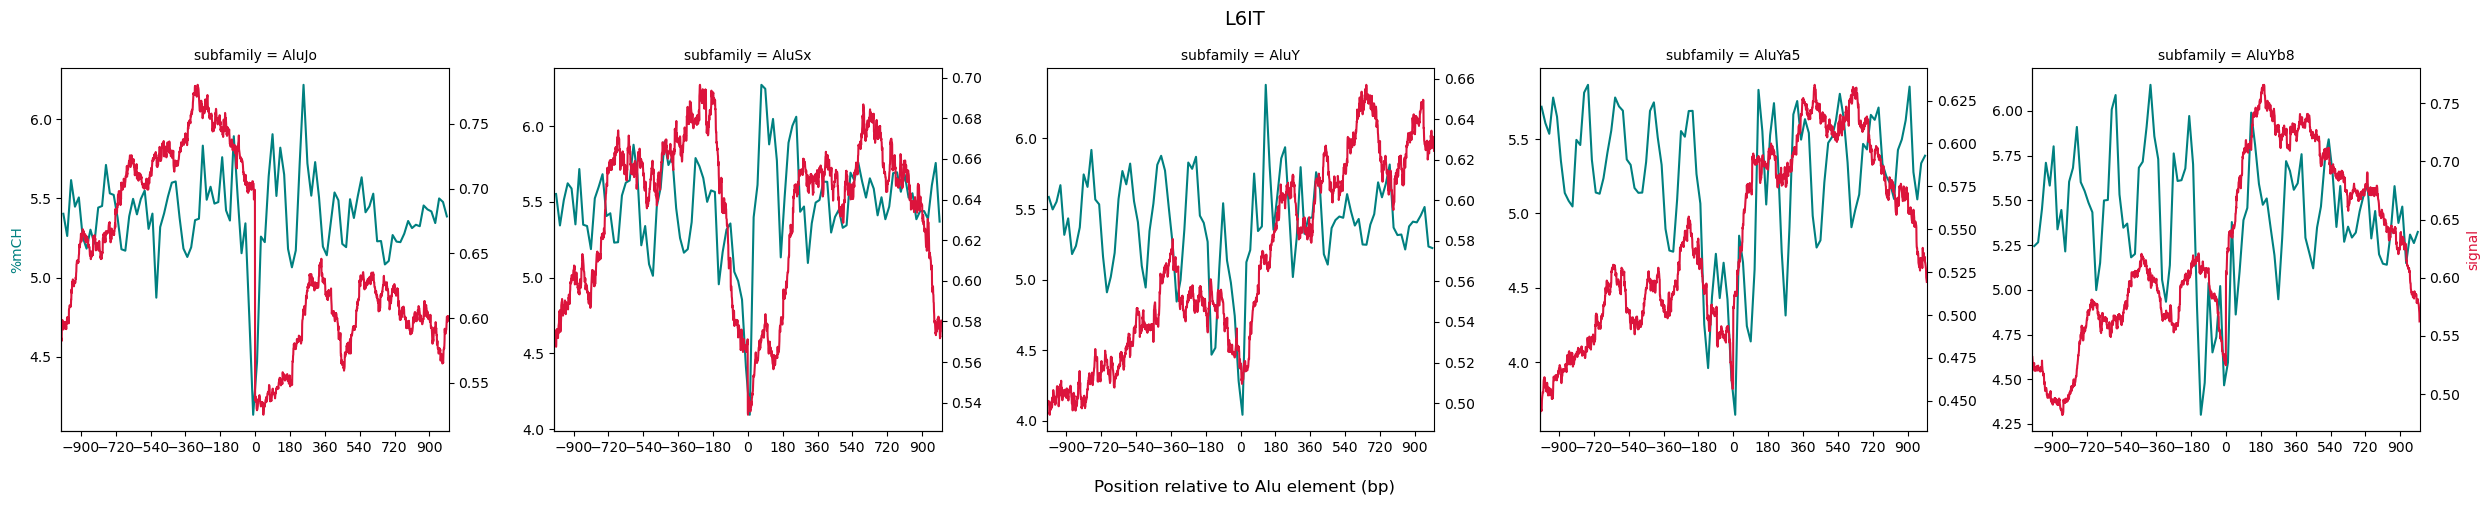

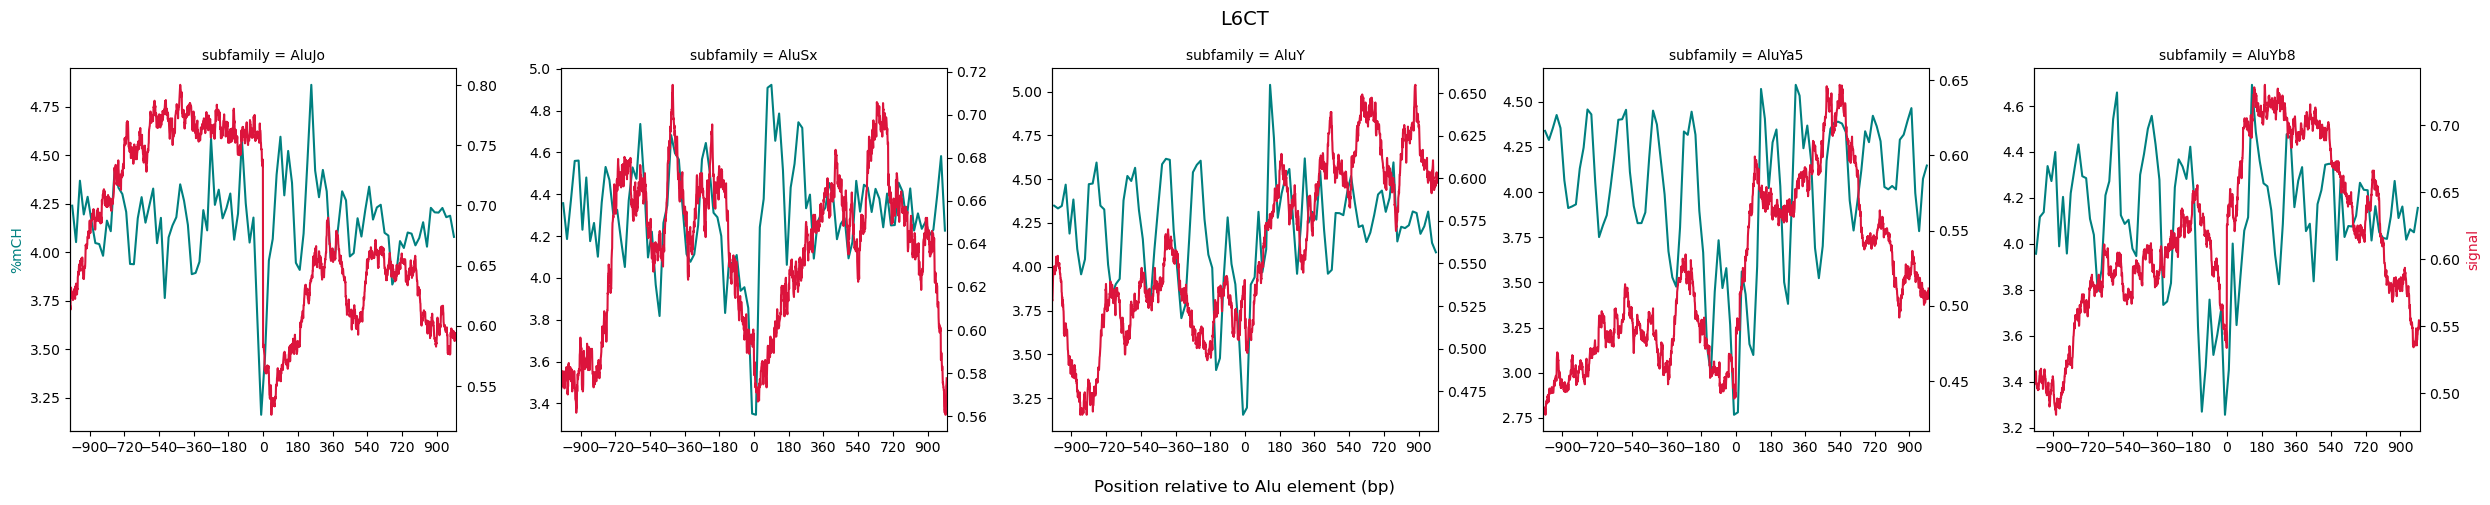

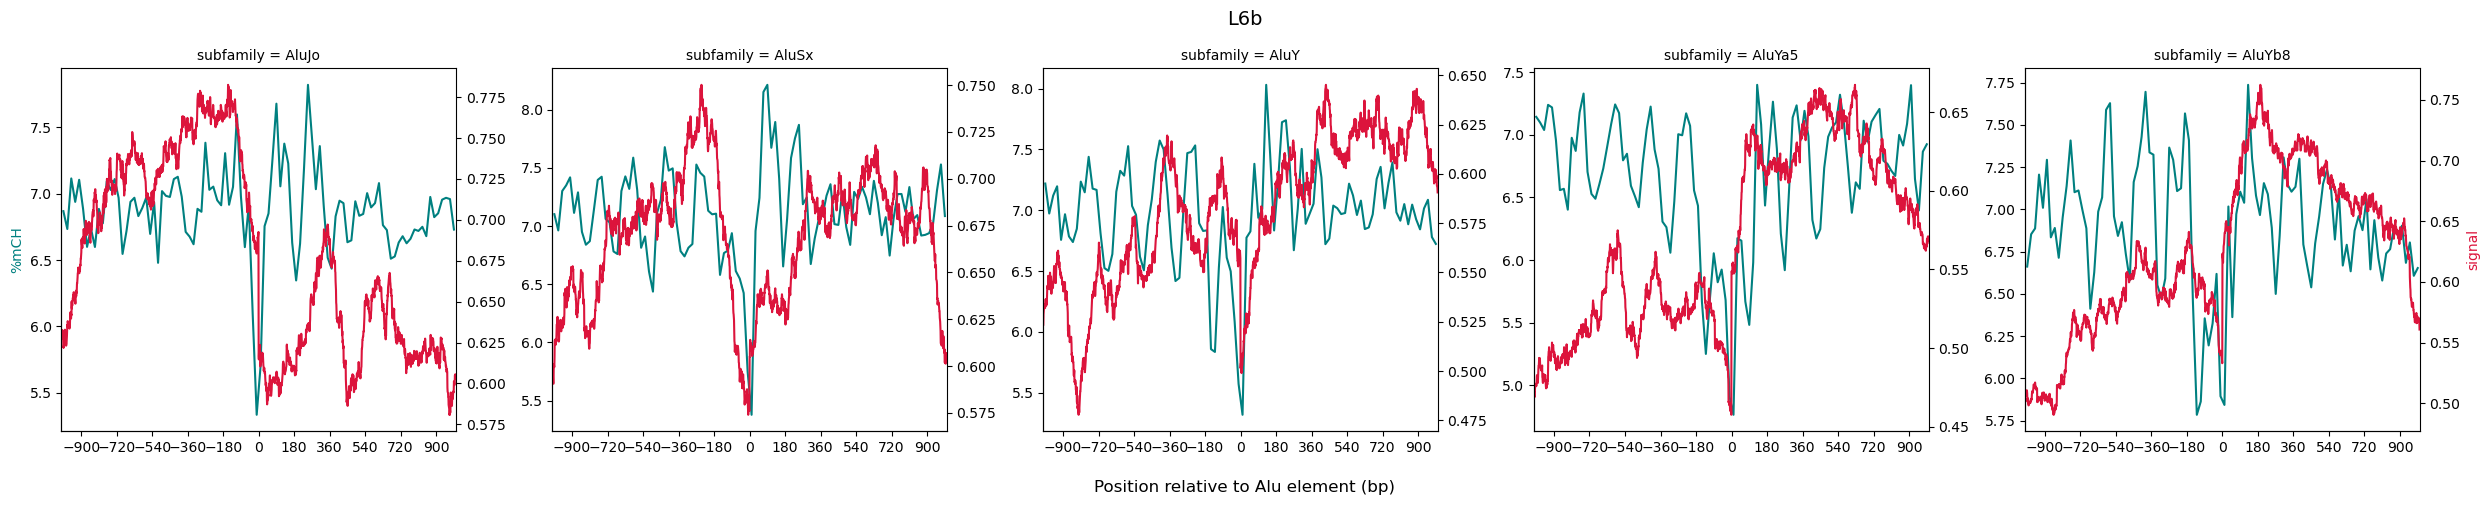

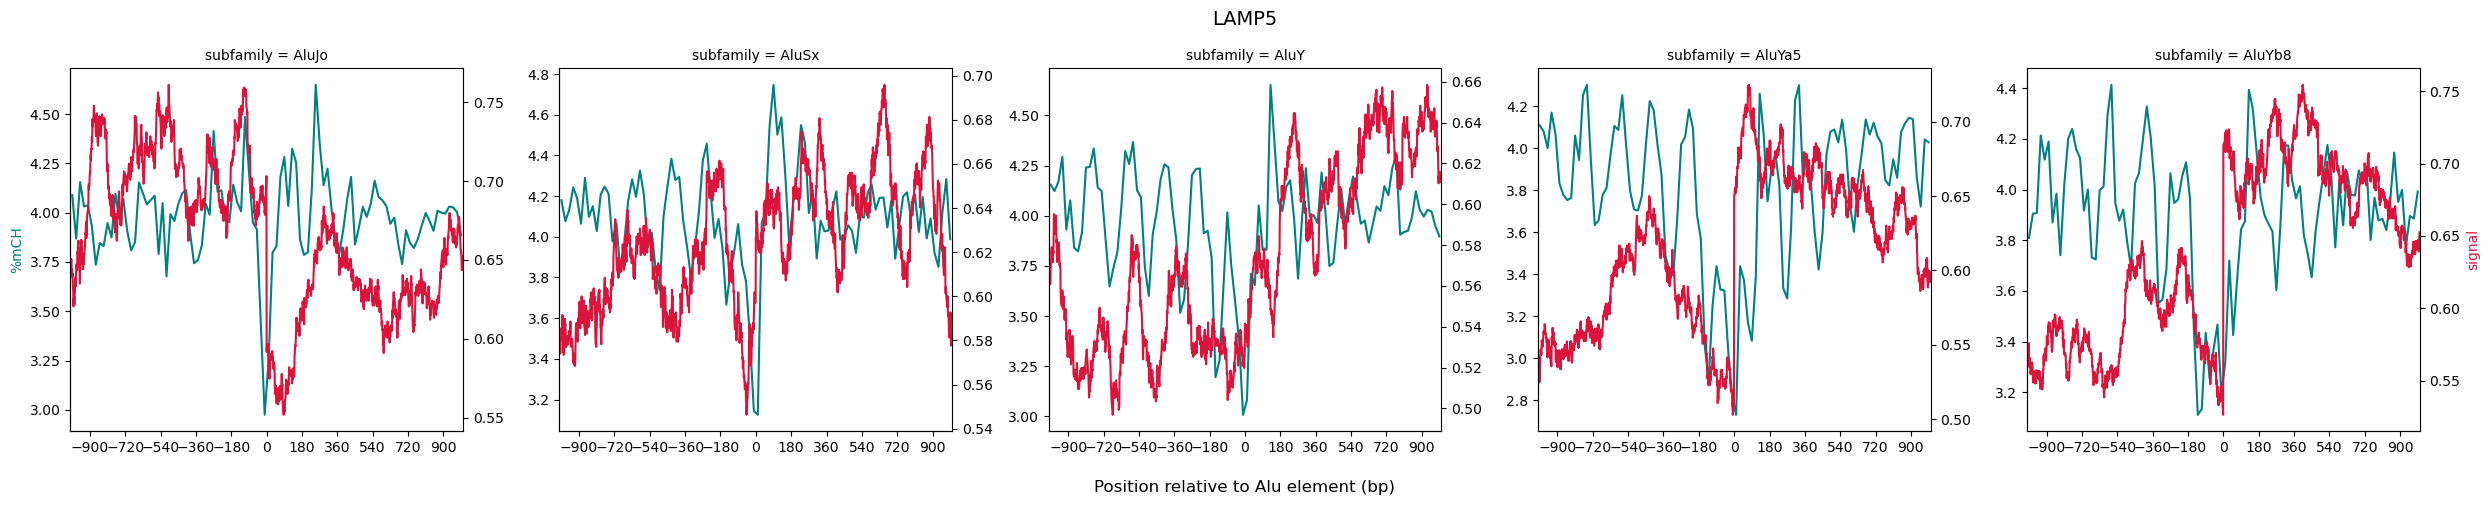

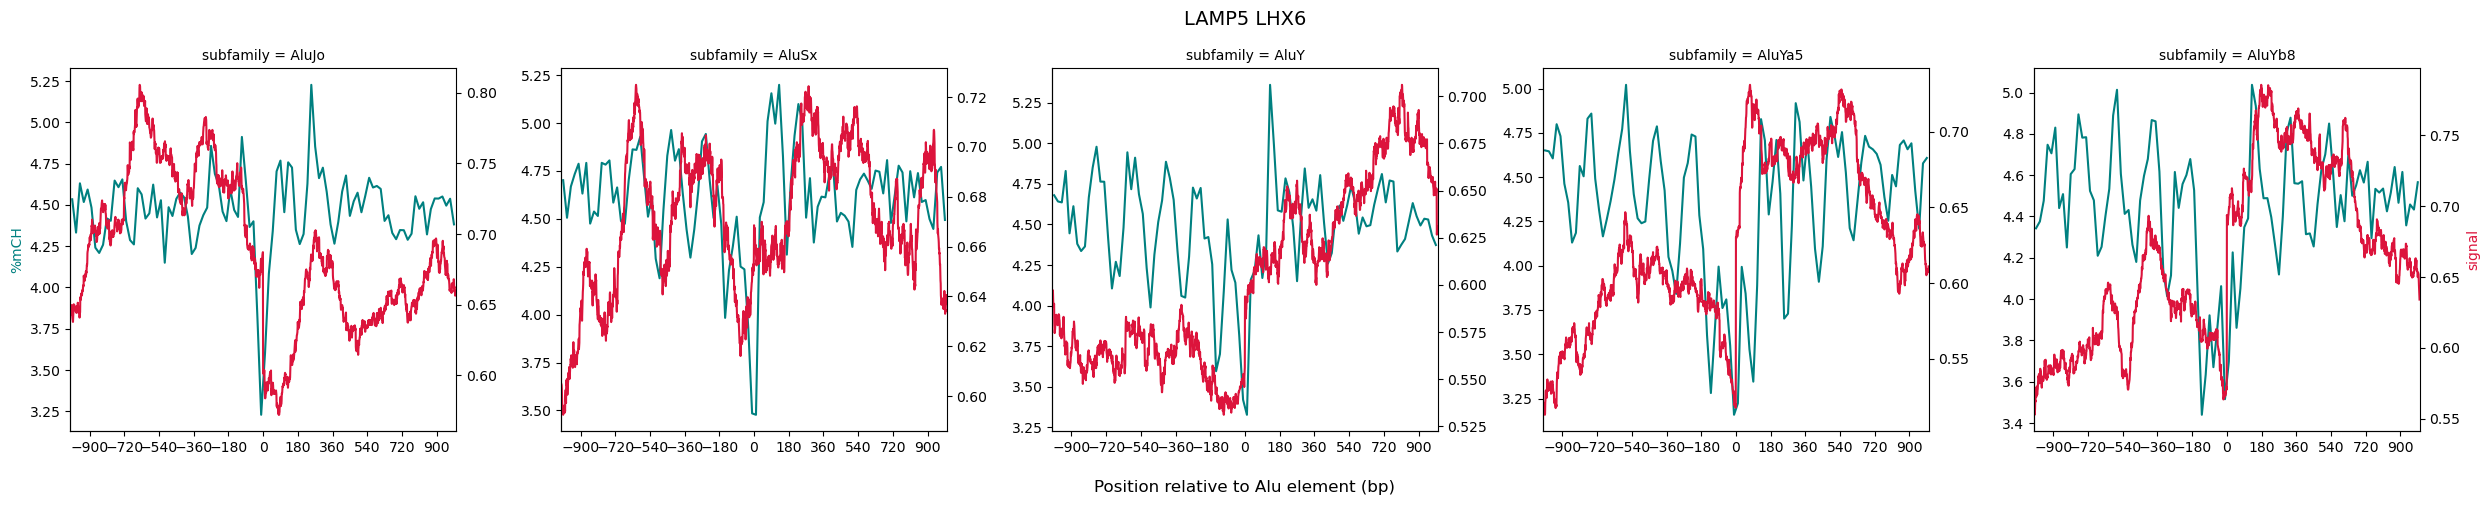

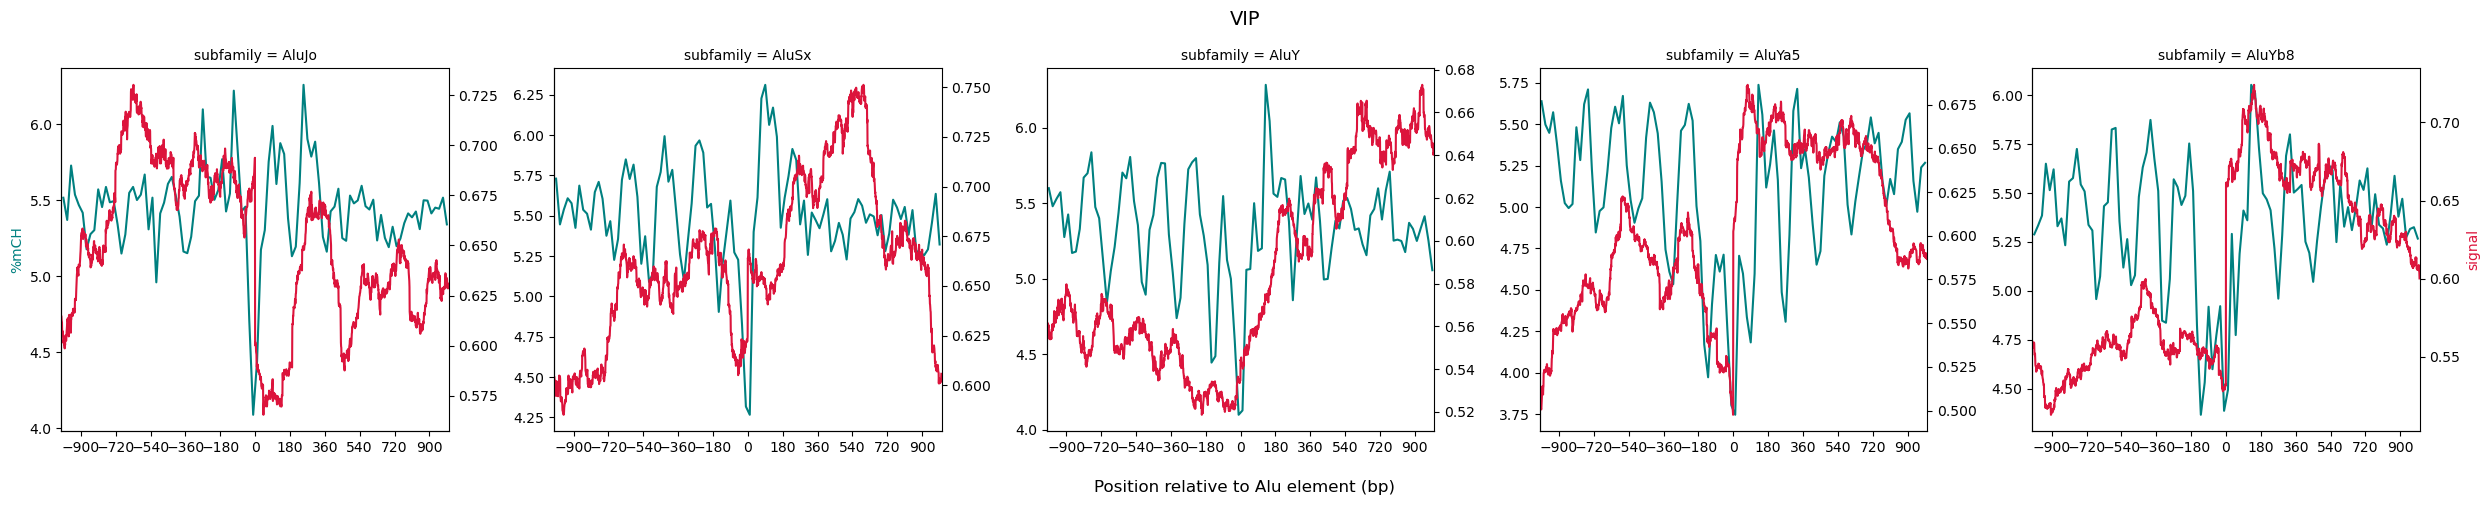

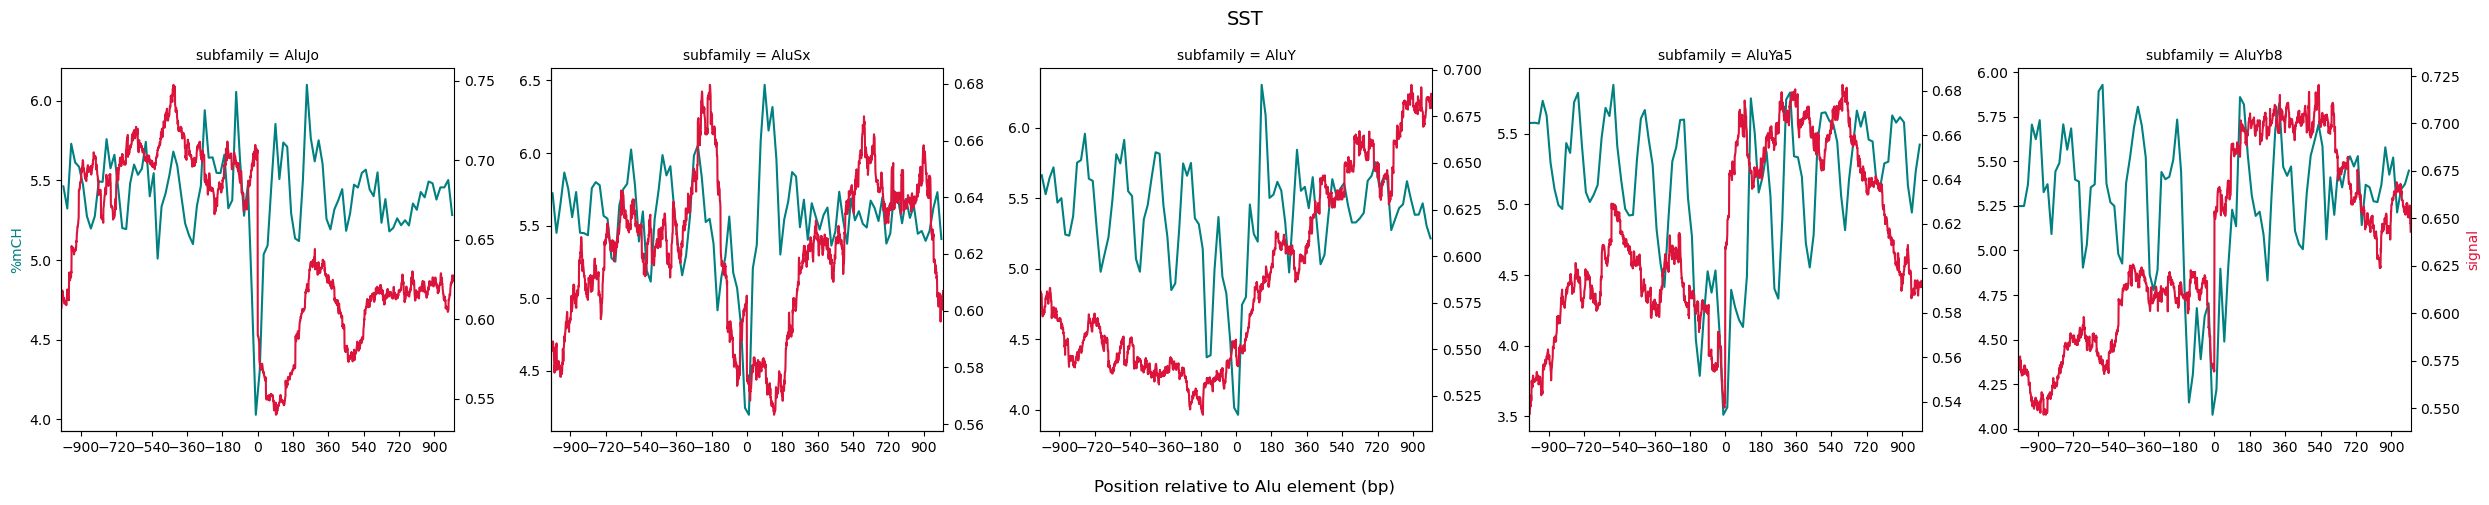

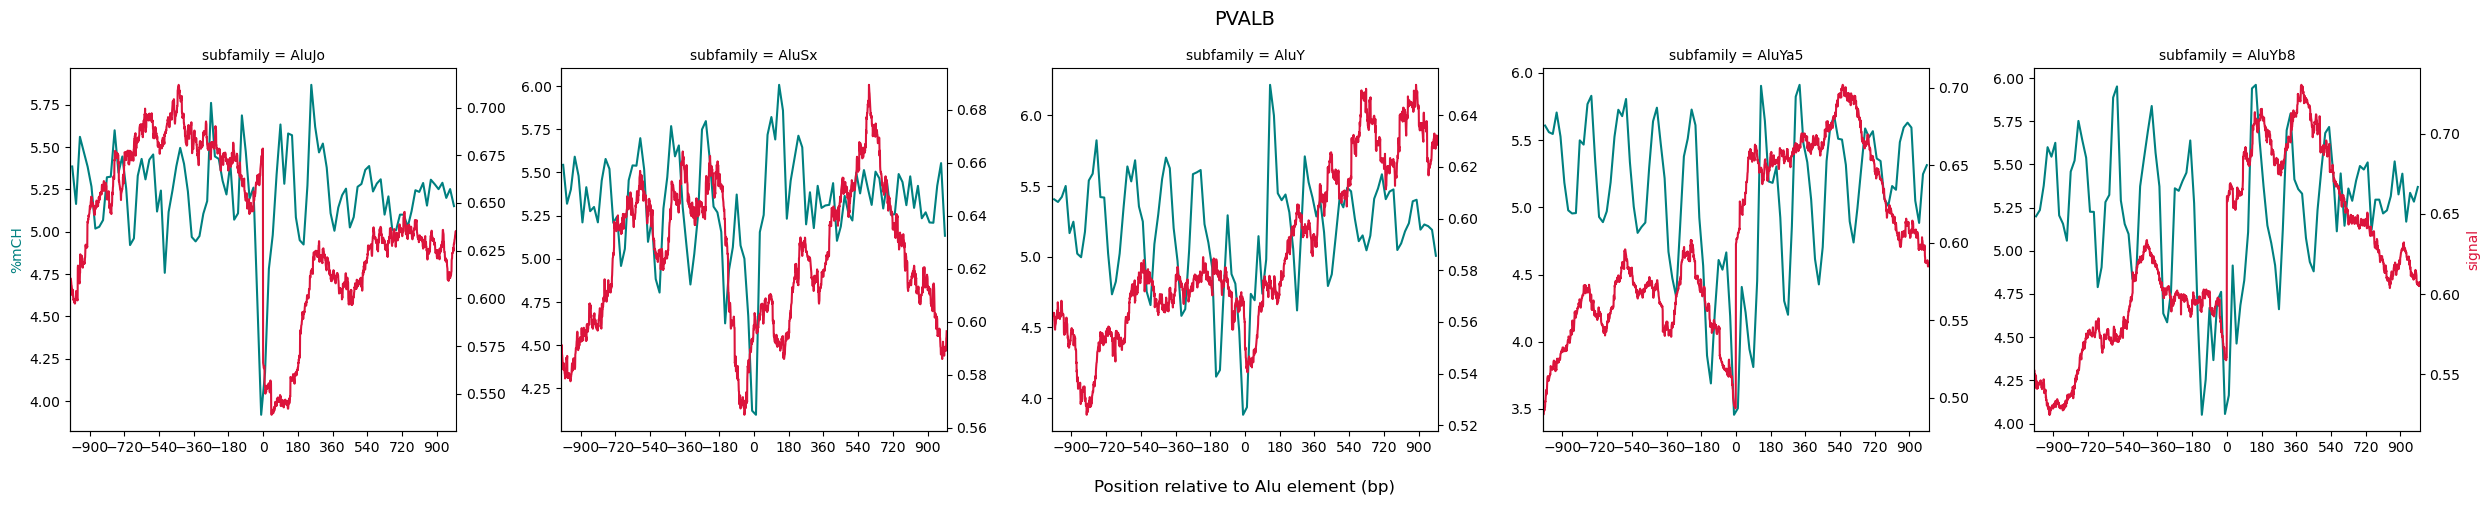

In [ ]:
for ct in atac_celltypes.values():
    g = sns.relplot(mc_map[mc_map['celltype'] == ct], kind='line', 
                x='bin', y='percent_mC', 
                col='subfamily', 
                legend=True,
                facet_kws={'sharex': True, 'sharey': False}, 
                color='teal', errorbar=None)

    bw_ct = bw_map[bw_map['celltype'] == ct]
    
    for fam, ax1 in g.axes_dict.items():
        ax2 = ax1.twinx()
        sns.lineplot(bw_ct[bw_ct['subfamily'] == fam], x='bin', y='signal', color='crimson', errorbar=None, ax=ax2)
        ax2.set_ylabel('')

    ax2.set_ylabel('signal', color='crimson') # only set y-label on last plot in the row

    g.set_xlabels('')
    g.set_ylabels('%mCH', color='teal')
    g.figure.supxlabel(f'Position relative to {me_type} element (bp)')
    g.figure.suptitle(ct, fontsize=14)

    plt.xlim([-1000,1000])
    plt.xticks(np.arange(-900, 1080, 180))
    plt.tight_layout()
    
    fn = f'{figdir}/all_{me_type}_{ct}_mCH_vs_ATAC_{region}.pdf'
    g.figure.savefig(fn, transparent=True, bbox_inches='tight')